In [1]:
import Models.SIRD as sird
import Models.SIRD_Time as sird_time
import Models.SIRD_Beta_Time as sird_beta

import Models.SAIRD as saird
import Models.SAIRD_Time as saird_time

import Models.SAIRD_Feedback as saird_fb

import Models.SIRD_Feedback as sird_fb

import Models.SIRD_Feedback_Delay as sird_fd

import Models.SIRD_Feedback_Delay

import Models.process as process

import numpy as np
import csv
import matplotlib.pyplot as plt
import platform

In [2]:
pathc = "../Data/Italian Data/"
#pathc="../Data/Covid Tracking State Data/"
if platform.system() == "Windows":
    pathc.replace("/", "\\")
    
filename = "National Data.csv"
#filename = "CA.csv"
dates, infectRaw, recovRaw, deadRaw = process.loadData(pathc + filename)

#recovRaw = process.getRecov(infectRaw, deadRaw)
#infectRaw = process.getCurrentInfect(infectRaw, recovRaw, deadRaw)

pop = 40000000

skipDays = 0
numDays = 160 #len(infectRaw) - 28 #just to get initial beginning data
#asympt = asymptRaw[skipDays:numDays]
infect = infectRaw[skipDays:numDays]
recov = recovRaw[skipDays:numDays] 
dead = deadRaw[skipDays:numDays]

daysToPredict = 110

## SIRD Feedback with delay

In [3]:
sird.weightDecay= .97
sird.regularizer=10

sird_fd.weightDecay = .97 #very small amount of decay
sird_fd.regularizer = 10
sird_fd.betaUseDecay = True

sird_fd.delay = 28

In [4]:
q = sird.getQ(infect,recov, dead, pop) #use non feedback model to get q value, should be accurate enough
print("q =", q)

#q=.011
suscept = process.getSuscept(infect,recov,dead, q,pop)

q = 0.244708808


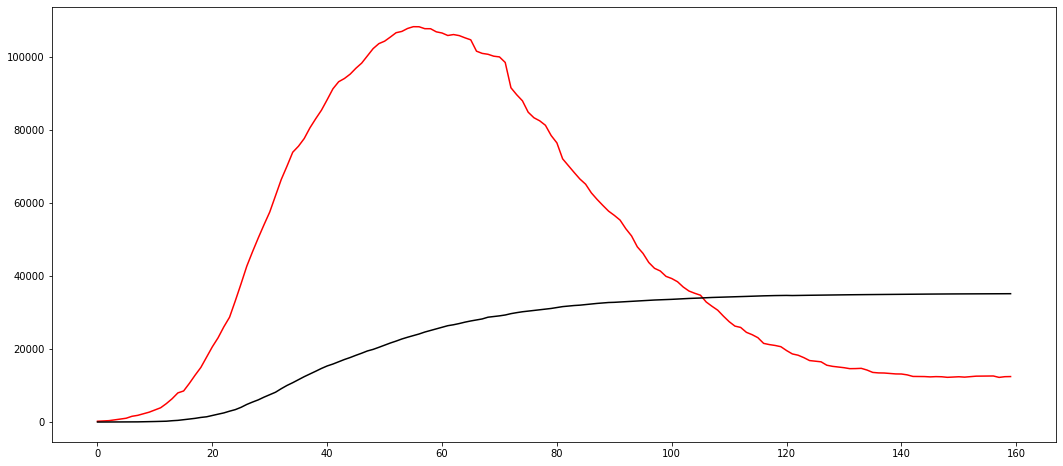

In [5]:
fig,ax = sird_fd.displayData(suscept, infect, recov, dead, graphVals=[0,1,0,1])

In [6]:
b1Range = (0, 5000)
b2Range = (0, 5)

betaVarsResol = [100, 15]

linVars, nonLinVars = sird_fd.solveAllVars(suscept, infect, recov, dead, [b1Range, b2Range], betaVarsResol, printOut=True)

Solution: 
b0:  -0.04551824535143164
b1:  0.1947966309172764
g:   0.030023497085678866
nu:  0.0031256514527479747
b2:  1550.0
b3:  0.3333333333333333
cost:  130445.95593318963



In [7]:
sirdLinVars = sird.getLinVars(suscept, infect, recov, dead)

print("cost: ", sird.getError(suscept, infect, recov, dead, sirdLinVars))

cost:  264639.9286517145


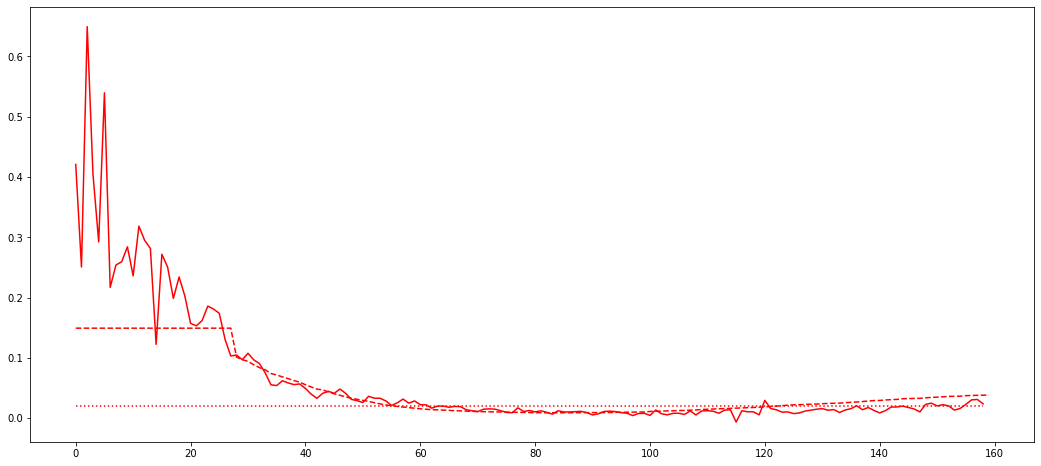

In [8]:
betaTime = sird_fd.getBetaTime(suscept, infect, recov, dead, linVars, nonLinVars)
linVarsTime = sird_time.getLinVars(suscept, infect, recov, dead)
linVarsConst = sird.getLinVars(suscept, infect, recov, dead)


fig, ax = plt.subplots(figsize=(18,8))
ax.plot(np.ones(len(linVarsTime[:,0]))*linVarsConst[0], color="red", linestyle="dotted") #constant beta
ax.plot(betaTime, color="red", linestyle="dashed") #feedback beta
ax.plot(linVarsTime[:,0], color="red") #time varying beta

Lin Vars: [0.019940801485544675, 0.030023497085678866, 0.0031256514527479747]
Non Lin Vars: [1550.0, 0.3333333333333333]
Lin Vars: [-0.04551824535143164, 0.1947966309172764, 0.030023497085678866, 0.0031256514527479747]


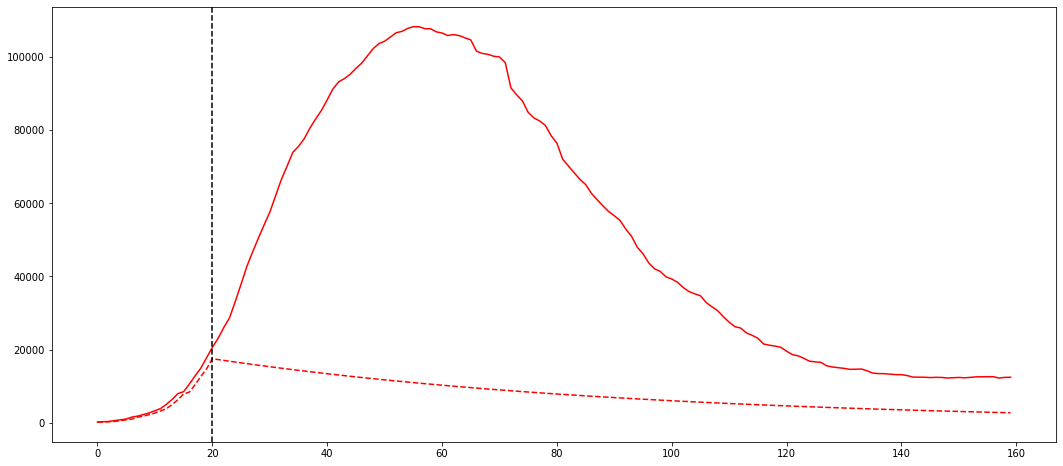

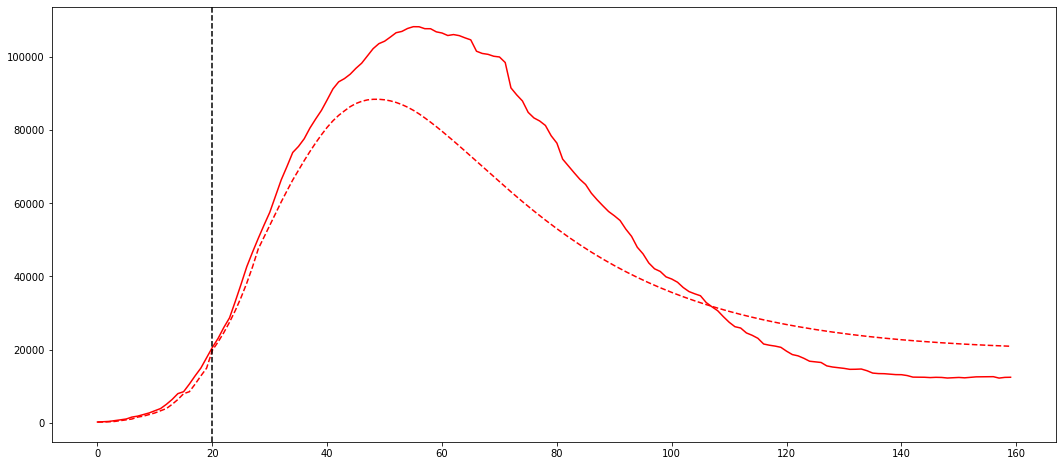

In [9]:
dTP= len(suscept) - 20


sird.predictMatch(suscept, infect, recov, dead, dTP, linVars=linVarsConst, graphVals=[0,1,0,0]);
sird_fd.predictMatch(suscept, infect, recov, dead, dTP, linVars=linVars, nonLinVars=nonLinVars, graphVals=[0,1,0,0]);

Lin Vars: [0.054835200563775256, 0.016760191205109375, 0.007916273690943772]
Non Lin Vars: [1550.0, 0.3333333333333333]
Lin Vars: [-0.04551824535143164, 0.1947966309172764, 0.030023497085678866, 0.0031256514527479747]
Non Lin Vars: [5000.0, 1.0]
Lin Vars: [0.02571288403532806, 0.09086213771153136, 0.016760191205109375, 0.007916273690943772]


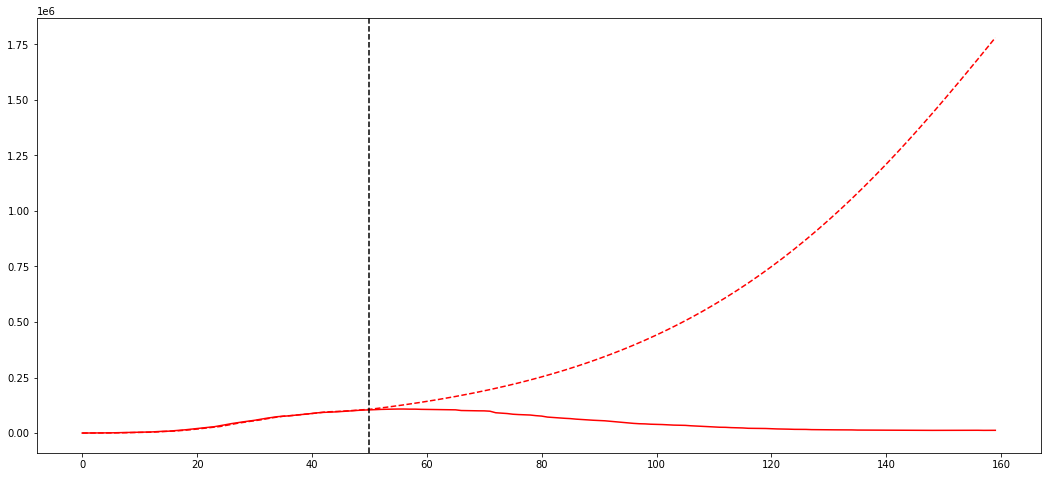

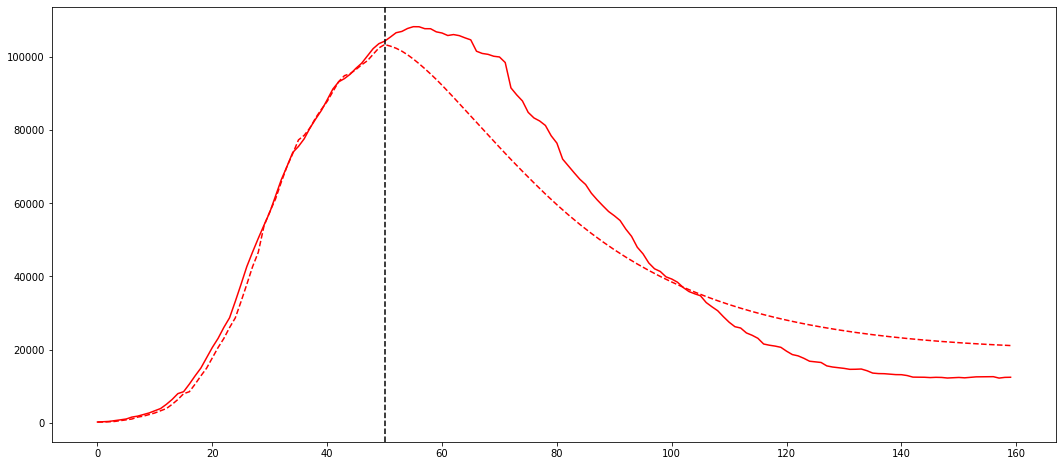

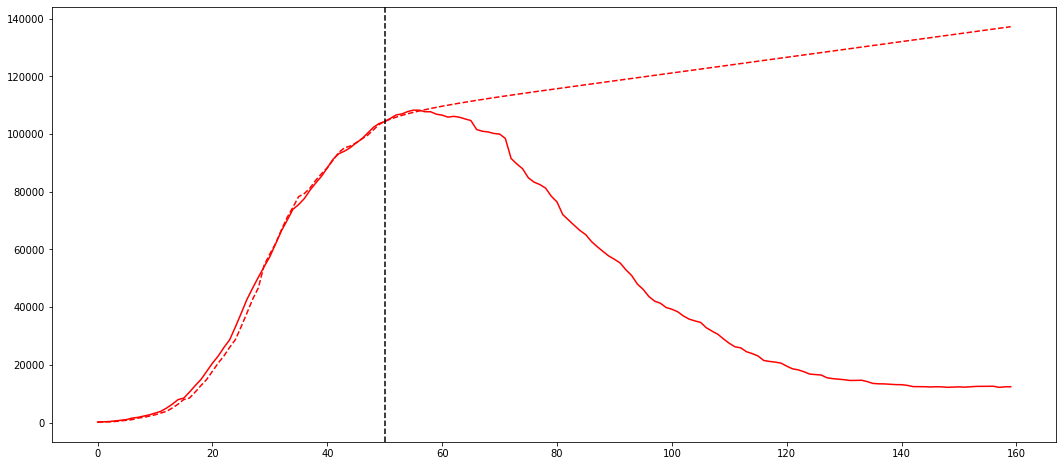

In [10]:
#daysToPredict = 180
sird.predictMatch(suscept, infect, recov, dead, daysToPredict, graphVals=[0,1,0,0]);

#note using the nonLinVars is trained on the whole data includinig the predicted days
sird_fd.predictMatch(suscept, infect, recov, dead, daysToPredict, linVars=linVars, nonLinVars=nonLinVars, graphVals=[0,1,0,0]);

#only train nonLinVars on the non predicted days only
sp,ip,rp,dp, fig, ax = sird_fd.predictMatch(suscept, infect, recov, dead, daysToPredict, graphVals=[0,1,0,0]);

## SAIRD Version

In [11]:
saird.weightDecay= .97
saird.regularizer=10

saird_fb.weightDecay = .97 #very small amount of decay
saird_fb.regularizer = 10
saird_fb.betaUseDecay = True

asymptDelay = 14

In [12]:
asymptRaw = saird.getAsympt(infectRaw, recovRaw, deadRaw, shift=asymptDelay)

asympt = asymptRaw[skipDays:numDays]

print(asympt)

[  7985.   8514.  10590.  12839.  14955.  17750.  20603.  23073.  26062.
  28710.  33190.  37860.  42681.  46638.  50418.  54030.  57521.  62013.
  66414.  70065.  73880.  75528.  77635.  80572.  83049.  85388.  88274.
  91246.  93187.  94067.  95262.  96877.  98273. 100269. 102253. 103616.
 104291. 105418. 106607. 106962. 107771. 108257. 108237. 107709. 107699.
 106848. 106527. 105847. 106103. 105813. 105205. 104657. 101551. 100943.
 100704. 100179.  99980.  98467.  91528.  89624.  87961.  84842.  83324.
  82488.  81266.  78457.  76440.  72070.  70187.  68351.  66553.  65129.
  62752.  60960.  59322.  57752.  56594.  55300.  52942.  50966.  47986.
  46175.  43691.  42097.  41367.  39893.  39297.  38429.  36976.  35877.
  35262.  34730.  32872.  31710.  30637.  28997.  27485.  26274.  25909.
  24569.  23925.  23101.  21543.  21212.  20972.  20637.  19573.  18655.
  18303.  17638.  16836.  16681.  16496.  15563.  15255.  15060.  14884.
  14621.  14642.  14709.  14242.  13595.  13459.  1

In [13]:
q = saird.getQ(asympt, infect, recov, dead, pop) #use non feedback model to get q value, should be accurate enough
print("q =", q)

#q=.011
suscept = saird.getSuscept(asympt, infect,recov,dead, q,pop)

q = 0.25464685


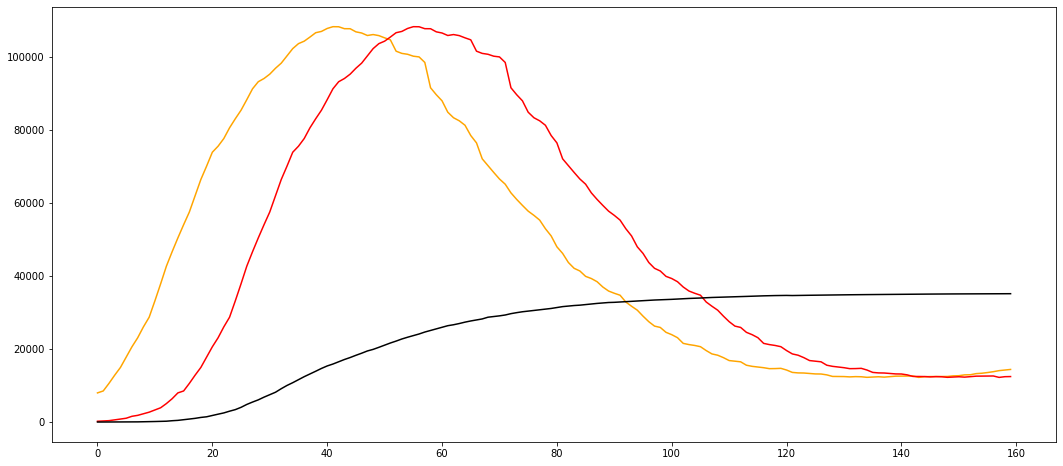

In [14]:
fig,ax = saird_fb.displayData(suscept, asympt, infect, recov, dead, graphVals=[0,1,1,0,1])

In [15]:
b1Range = (0, 5000)
b2Range = (0, 5)

betaVarsResol = [100, 15]

linVars, nonLinVars = saird_fb.solveAllVars(suscept, asympt, infect, recov, dead, [b1Range, b2Range], betaVarsResol, printOut=True)

Solution: 
b0:  0.01405747649229445
b1:  0.1327034038822514
k:   0.026231132328385563
g:   0.030023497085678866
nu:  0.0031256514527479747
b2:  1250.0
b3:  4.0
cost:  388442.5143403355



In [16]:
sairdLinVars = saird.getLinVars(suscept, asympt, infect, recov, dead)

print("cost: ", saird.getError(suscept, asympt, infect, recov, dead, sairdLinVars))

cost:  432812.90949605615


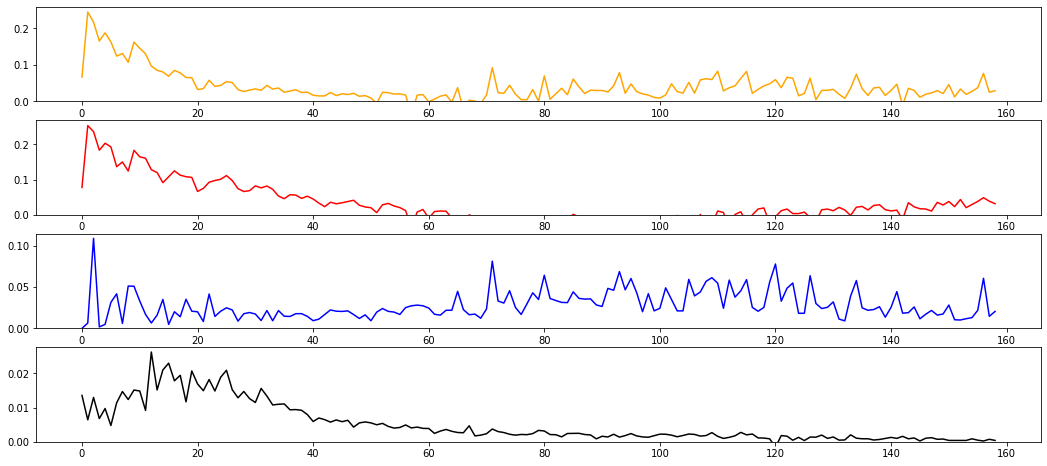

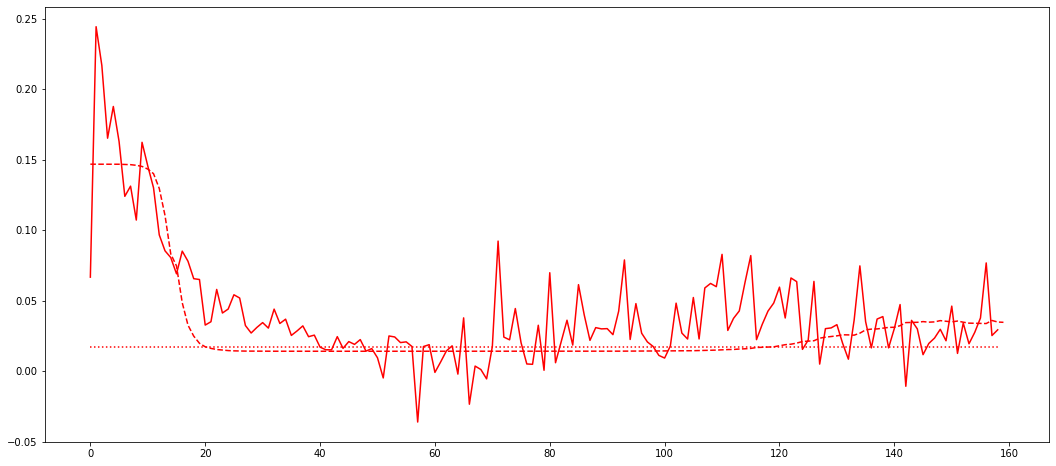

In [17]:
betaTime = saird_fb.getBetaTime(suscept, asympt, infect, recov, dead, linVars, nonLinVars)
linVarsTime, fig2, ax2 = saird_time.getLinVars(suscept, asympt, infect, recov, dead, graph=True)
linVarsConst = saird.getLinVars(suscept, asympt, infect, recov, dead)


fig, ax = plt.subplots(figsize=(18,8))
ax.plot(np.ones(len(linVarsTime[:,0]))*linVarsConst[0], color="red", linestyle="dotted") #constant beta
ax.plot(betaTime, color="red", linestyle="dashed") #feedback beta
ax.plot(linVarsTime[:,0], color="red") #time varying beta

Lin Vars: [0.017313776847010187, 0.026231132328385563, 0.030023497085678866, 0.0031256514527479747]
Non Lin Vars: [1250.0, 4.0]
Lin Vars: [0.01405747649229445, 0.1327034038822514, 0.026231132328385563, 0.030023497085678866, 0.0031256514527479747]


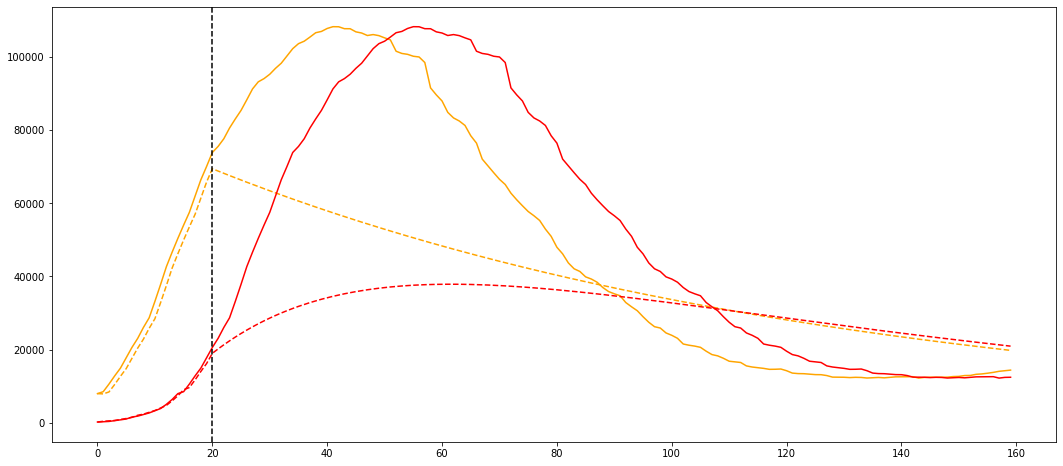

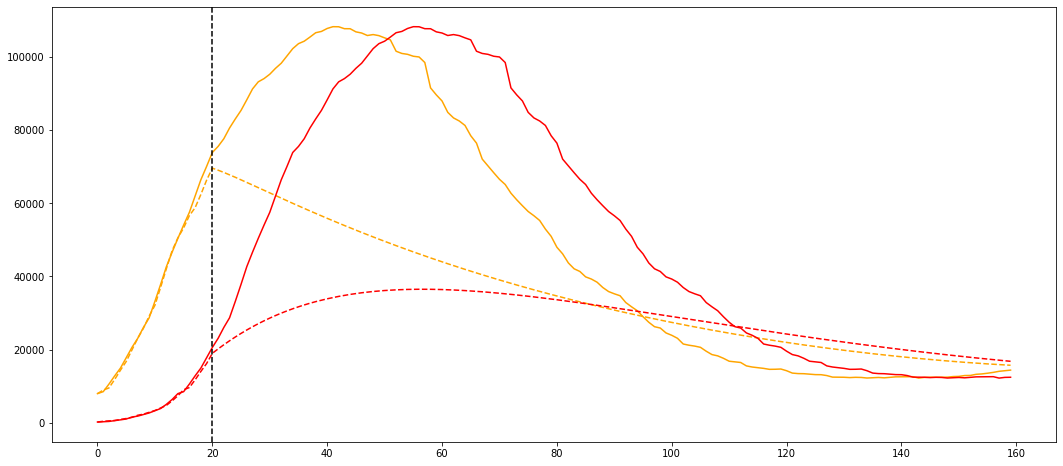

In [18]:
dTP= len(suscept) - 20


saird.predictMatch(suscept, asympt, infect, recov, dead, dTP, linVars=linVarsConst, graphVals=[0,1,1,0,0]);
saird_fb.predictMatch(suscept, asympt, infect, recov, dead, dTP, linVars=linVars, nonLinVars=nonLinVars, graphVals=[0,1,1,0,0]);

Lin Vars: [0.056206892815356575, 0.029300245453939902, 0.016760191205109375, 0.007916273690943772]
Non Lin Vars: [1250.0, 4.0]
Lin Vars: [0.01405747649229445, 0.1327034038822514, 0.026231132328385563, 0.030023497085678866, 0.0031256514527479747]
Non Lin Vars: [100.0, 1.0]
Lin Vars: [-0.05353312309392575, 0.1652152906483019, 0.029300245453939902, 0.016760191205109375, 0.007916273690943772]


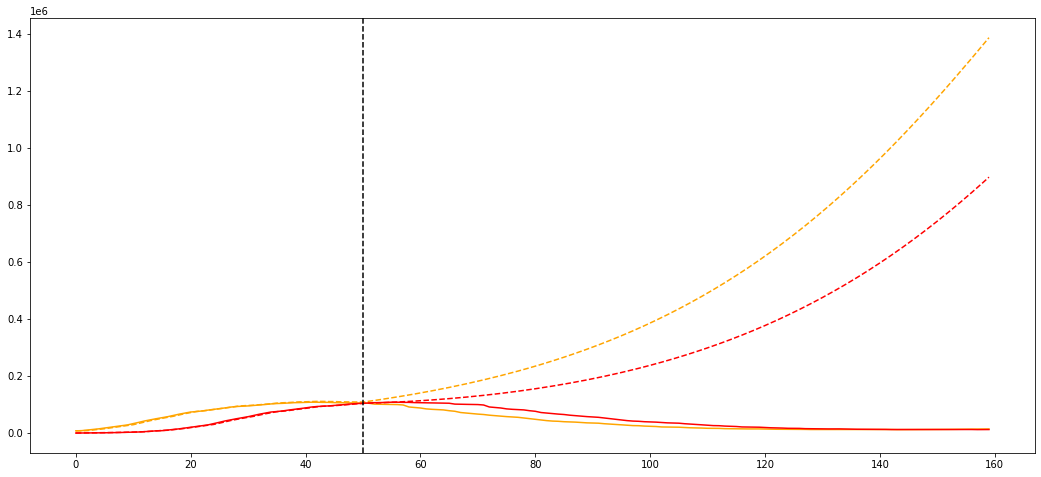

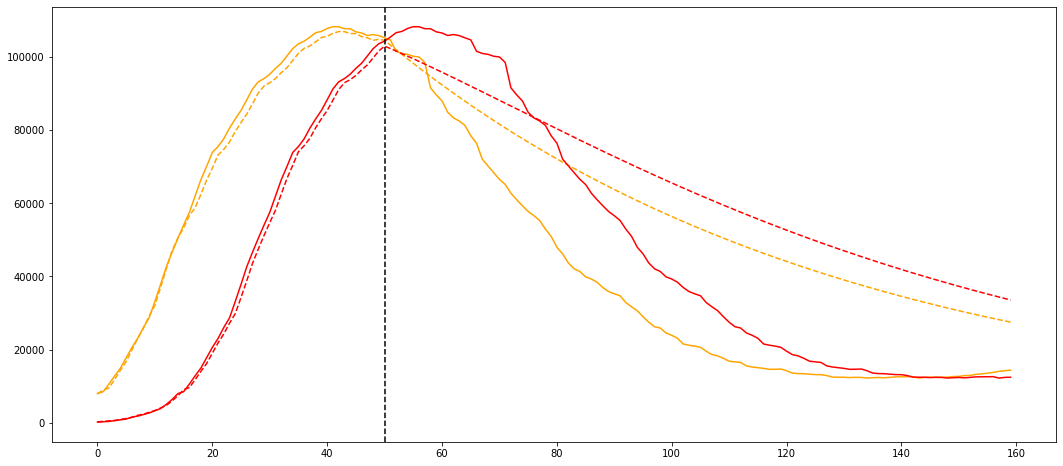

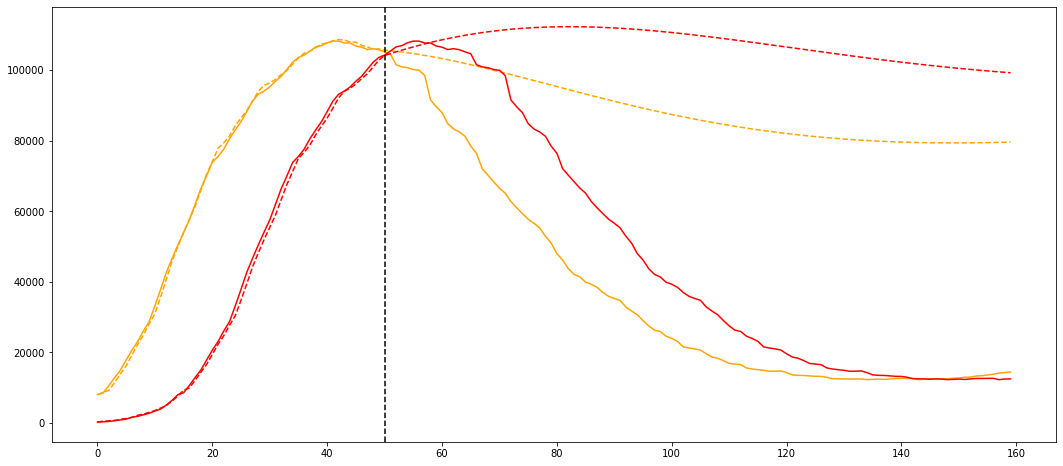

In [19]:
#daysToPredict = 180
saird.predictMatch(suscept, asympt, infect, recov, dead, daysToPredict, graphVals=[0,1,1,0,0]);

#note using the nonLinVars is trained on the whole data includinig the predicted days
saird_fb.predictMatch(suscept, asympt, infect, recov, dead, daysToPredict, linVars=linVars, nonLinVars=nonLinVars, graphVals=[0,1,1,0,0]);

#only train nonLinVars on the non predicted days only
saird_fb.predictMatch(suscept, asympt, infect, recov, dead, daysToPredict, graphVals=[0,1,1,0,0]);